In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Retrieving the coffee production schedule

In [2]:
coffee_harvest_schedule = pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0)
coffee_harvest_schedule.head(8)


,Producing Country,Harvest Begins,Harvest Ends,Year-round Harvest,Arabica,Robusta
0,Angola,4,6,False,True,False
1,Angola,5,9,False,False,True
2,Benin,11,2,False,False,True
3,Bolivia,4,8,False,True,False
4,Borneo,6,12,False,True,False
5,Borneo,5,12,False,False,True
6,Brazil,4,9,False,True,False
7,Brazil,4,9,False,False,True


### Defining functions

In [3]:
# Determining seasons by month
def get_season (month, hemisphere = None):
    northern_hemisphere_seasons = {1: 'Winter', 2: 'Winter', 3: 'Winter', 4: 'Spring', 5: 'Spring', 6: 'Spring', 7: 'Summer', 8: 'Summer', 9: 'Summer', 10: 'Fall', 11: 'Fall', 12: 'Fall'}
    southern_hemisphere_seasons = {7: 'Winter', 8: 'Winter', 9: 'Winter', 10: 'Spring', 11: 'Spring', 12: 'Spring', 1: 'Summer', 2: 'Summer', 3: 'Summer', 4: 'Fall', 5: 'Fall', 6: 'Fall'}

    if hemisphere.lower() == "northern":
        season = northern_hemisphere_seasons[month]
    elif hemisphere.lower() == "southern":
        season = southern_hemisphere_seasons[month]
    
    return season

In [4]:
# Converting date fraction to datetime
def convert_date_fraction_series_to_datetime(series = None):
    
    # Separate month decimal and year
    month_decimal = np.mod(series, 1)
    year = (series - month_decimal).astype(int)
    
    # Convert month decimal to month integer (1 = January, 2 = February, etc.)
    month = np.round(12 * month_decimal + 0.5).astype(int)
    
    # Concatenate the values together into a string
    date = year.astype(str) + "-" + month.astype(str) + "-01"
    
    # Convert the date strings into datetime values
    series = pd.to_datetime(date, yearfirst = True)
    
    return series

In [5]:
def observation_in_harvest_season(temperature_data_row):
    country = temperature_data_row["Country"]
    crop = ("Robusta", "Arabica")[temperature_data_row["Arabica Production"]]
    month = temperature_data_row.name.month
#     crop = ("Robusta", "Arabica")[arabica_crop]
    harvest_schedule = coffee_harvest_schedule[(coffee_harvest_schedule["Producing Country"] == country) 
                                  & (coffee_harvest_schedule[crop])][["Harvest Begins", "Harvest Ends"]]
    harvest_month_range = harvest_schedule.values.tolist()[0]
    return(harvest_month_range[0] <= month <= harvest_month_range[1])

# observation_in_harvest_season(temperature_data[(temperature_data["Country"] == "Angola") & (temperature_data.index.month == 4)].iloc[0])
# for row in temperature_data[(temperature_data["Country"] == "Angola")].iterrows():
#     print(observation_in_harvest_season(row[1]))
    

### Selecting weather stations by growing conditions

In [6]:
raw_station_data = pd.read_csv("../datasets/capstone/downloaded data/berkeley_earth_stations--site_detail.txt", 
                               delimiter = "\t", 
                               skiprows =148, 
                               names = ["Station ID", 
                                        "Station Name", 
                                        "Latitude", 
                                        "Longitude", 
                                        "Elevation (m)", 
                                        "Lat. Uncertainty", 
                                        "Long. Uncertainty", 
                                        "Elev. Uncertainty (m)", 
                                        "Country", 
                                        "State / Province Code", 
                                        "County", 
                                        "Time Zone", 
                                        "WMO ID", 
                                        "Coop ID", 
                                        "WBAN ID", 
                                        "ICAO ID", 
                                        "# of Relocations", 
                                        "# Suggested Relocations", 
                                        "# of Sources", 
                                        "Hash"])

In [7]:
raw_station_data.head()

,Station ID,Station Name,Latitude,Longitude,Elevation (m),Lat. Uncertainty,Long. Uncertainty,Elev. Uncertainty (m),Country,State / Province Code,County,Time Zone,WMO ID,Coop ID,WBAN ID,ICAO ID,# of Relocations,# Suggested Relocations,# of Sources,Hash
0,34,UNIV. WI ID 8917 (SKY-BLU,-74.78368,-71.48333,1589.00,0.00868,0.00833,0.50000,Antarctica,,,-99,89272,-9999,-9999,,0,5,2,6aaa6e8215ce02e2295e6ebef3745243
1,63,ADMIRALTY BAY,-62.06700,-58.40000,9.00,0.00050,0.00050,0.05000,Antarctica,,,-99,-9999,-9999,-9999,,0,0,1,5fe87a7a0ae8e2b2827ddb62219fda7b
2,64,DECEPTION IS S SMET IS,-61.01700,-59.43300,7.90,0.00050,0.00050,0.05000,[Missing],,,-99,-9999,-9999,-9999,,0,0,1,cf753a8488c3ed6fce1a1dc9d5a062ba
3,81,FOZ DO IGUACU AEROPORTO,-25.51667,-54.58333,160.36,0.00833,0.00833,112.59289,Brazil,,,-99,83827,-9999,-9999,,0,0,1,b73a91b552c4b7ff6d1b0eda1b345cc5
4,88,ISLA TRINDADE,-20.50000,-29.31667,1.76,0.00833,0.00833,25.16368,Brazil,,,-99,83650,-9999,-9999,,0,0,1,3ba691e6d9d96991f9945a6769441f0e


### Cleaning station data

In [8]:
station_data = raw_station_data.copy()

# Select only relevant columns
station_data = station_data[["Station ID", "Station Name", "Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)", "Country"]]

# Convert values in numerical columns
numeric_columns_in_stations_data = ["Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)"]
station_data.loc[:, numeric_columns_in_stations_data] = station_data[numeric_columns_in_stations_data].apply(pd.to_numeric, errors = 'coerce')

# Remove whitespace from non-numerical columns
station_data.loc[:, "Station Name"] = station_data["Station Name"].str.strip()
station_data.loc[:, "Country"] = station_data["Country"].str.strip()

# Filter data to select stations in coffee growing regions
stations_in_coffee_producing_countries = station_data[station_data["Country"].isin(coffee_harvest_schedule["Producing Country"])]

hemisphere_dictionary = (station_data.groupby(by = "Country")["Latitude"].mean() > 0).map({True: "Northern", False: "Southern"}).to_dict()


### Making filter for coffee growing regions

In [9]:
# Arabica grows best in elevations 548 m – 1100 m for latitudes between 16° and 24°, or 1097 m – 1920 m for latitudes less that ±10°
arabica_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] >= 548) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1100) & (stations_in_coffee_producing_countries["Latitude"].abs() > 16) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 24)
arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((stations_in_coffee_producing_countries["Elevation (m)"] >= 1097) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1920) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10))

# Robusta grows best in elevations 0 m – 914 m in latitudes between ±10°
robusta_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] <= 914) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10)

# Select the stations in the ideal coffee growing regions
stations_in_arabica_conditions = stations_in_coffee_producing_countries[arabica_growing_conditions_criteria]["Station ID"]
stations_in_robusta_conditions = stations_in_coffee_producing_countries[robusta_growing_conditions_criteria]["Station ID"]

stations_in_arabica_conditions_dictionary = dict.fromkeys(stations_in_arabica_conditions.values, True)
stations_in_robusta_conditions_dictionary = dict.fromkeys(stations_in_robusta_conditions.values, True)


### Importing weather data

In [10]:
# Import raw temperature data from Berkeley Earth
raw_temperature_data = pd.read_csv("../datasets/capstone/downloaded data/berkeley_earth -- data.txt", 
            delimiter = "\t",  
            skiprows = 111, 
            names = ["Station ID", 
                     "Series Number", 
                     "Date", 
                     "Temperature (C)", 
                     "Uncertainty (C)", 
                     "Observations", 
                     "Time of Observation"])

In [11]:
raw_temperature_data.head()

,Station ID,Series Number,Date,Temperature (C),Uncertainty (C),Observations,Time of Observation
0,34,1,2006.542,-34.258,0.05,-99,-99
1,34,1,2006.708,-33.558,0.05,-99,-99
2,34,1,2006.792,-20.458,0.05,-99,-99
3,34,1,2006.875,-21.958,0.05,-99,-99
4,34,1,2006.958,-17.358,0.05,22,-99


### Cleaning weather data

In [12]:
temperatures_for_all_stations = raw_temperature_data.copy()

# Remove unnecessary labels
temperatures_for_all_stations.drop(labels = ["Series Number", "Uncertainty (C)", "Observations", "Time of Observation"], axis = 1, inplace = True)

# Select the temperature data for stations in coffee growing regions, and add country names
temperatures_for_coffee_producing_countries = temperatures_for_all_stations[temperatures_for_all_stations["Station ID"].isin(stations_in_coffee_producing_countries["Station ID"])]
temperatures_for_coffee_producing_countries = stations_in_coffee_producing_countries[["Station ID", "Country"]].merge(temperatures_for_coffee_producing_countries, on = "Station ID")

# Add columns indicating each station's hemisphere (for seasonality calculations later)
temperatures_for_coffee_producing_countries["Hemisphere"] = temperatures_for_coffee_producing_countries["Country"].map(hemisphere_dictionary)

# Designate stations in areas that grow arabica and robusta coffee
temperatures_for_coffee_producing_countries["Arabica Production"] = temperatures_for_coffee_producing_countries["Station ID"].map(stations_in_arabica_conditions_dictionary)
temperatures_for_coffee_producing_countries["Robusta Production"] = temperatures_for_coffee_producing_countries["Station ID"].map(stations_in_robusta_conditions_dictionary)
temperatures_for_coffee_producing_countries = temperatures_for_coffee_producing_countries.fillna(False)

# Keep the stations in areas that grow arabica or robusta coffee
temperature_data = temperatures_for_coffee_producing_countries[
    temperatures_for_coffee_producing_countries["Arabica Production"]
    | temperatures_for_coffee_producing_countries["Robusta Production"]]

# Drop the Station ID column since it's no longer needed
temperature_data.drop("Station ID", axis = 1, inplace = True)

# Convert dates to datetime values
temperature_data.loc[:, "Date"] = convert_date_fraction_series_to_datetime(temperature_data["Date"])

# Index by date
temperature_data.index = temperature_data["Date"].values
temperature_data = temperature_data.sort_index()
temperature_data = temperature_data.drop("Date", axis = 1)

# Add seasons columns
temperature_data["Season"] = temperature_data.index.month
temperature_data.loc[temperature_data["Hemisphere"] == "Northern", "Season"] = temperature_data[temperature_data["Hemisphere"] == "Northern"]["Season"].apply(lambda x: get_season(x, hemisphere = "Northern"))
temperature_data.loc[temperature_data["Hemisphere"] == "Southern", "Season"] = temperature_data[temperature_data["Hemisphere"] == "Southern"]["Season"].apply(lambda x: get_season(x, hemisphere = "Southern"))


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Feature engineering

In [13]:
# Add frost likelihood
temperature_data["Frost likelihood"] = temperature_data["Temperature (C)"] ** -2

### Visualizing stations in growing regions

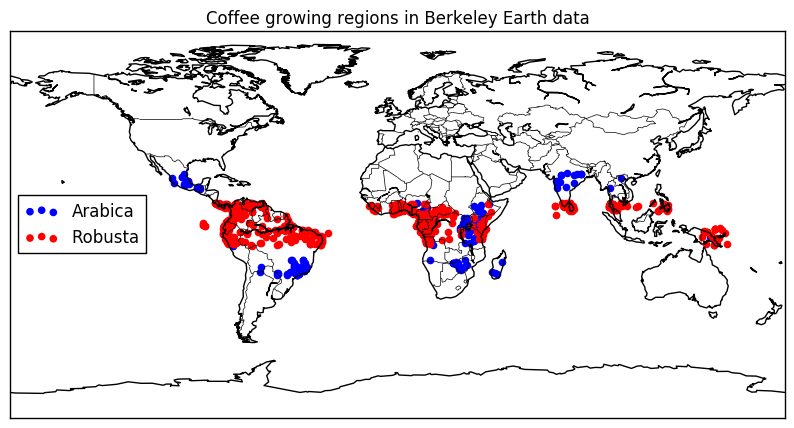

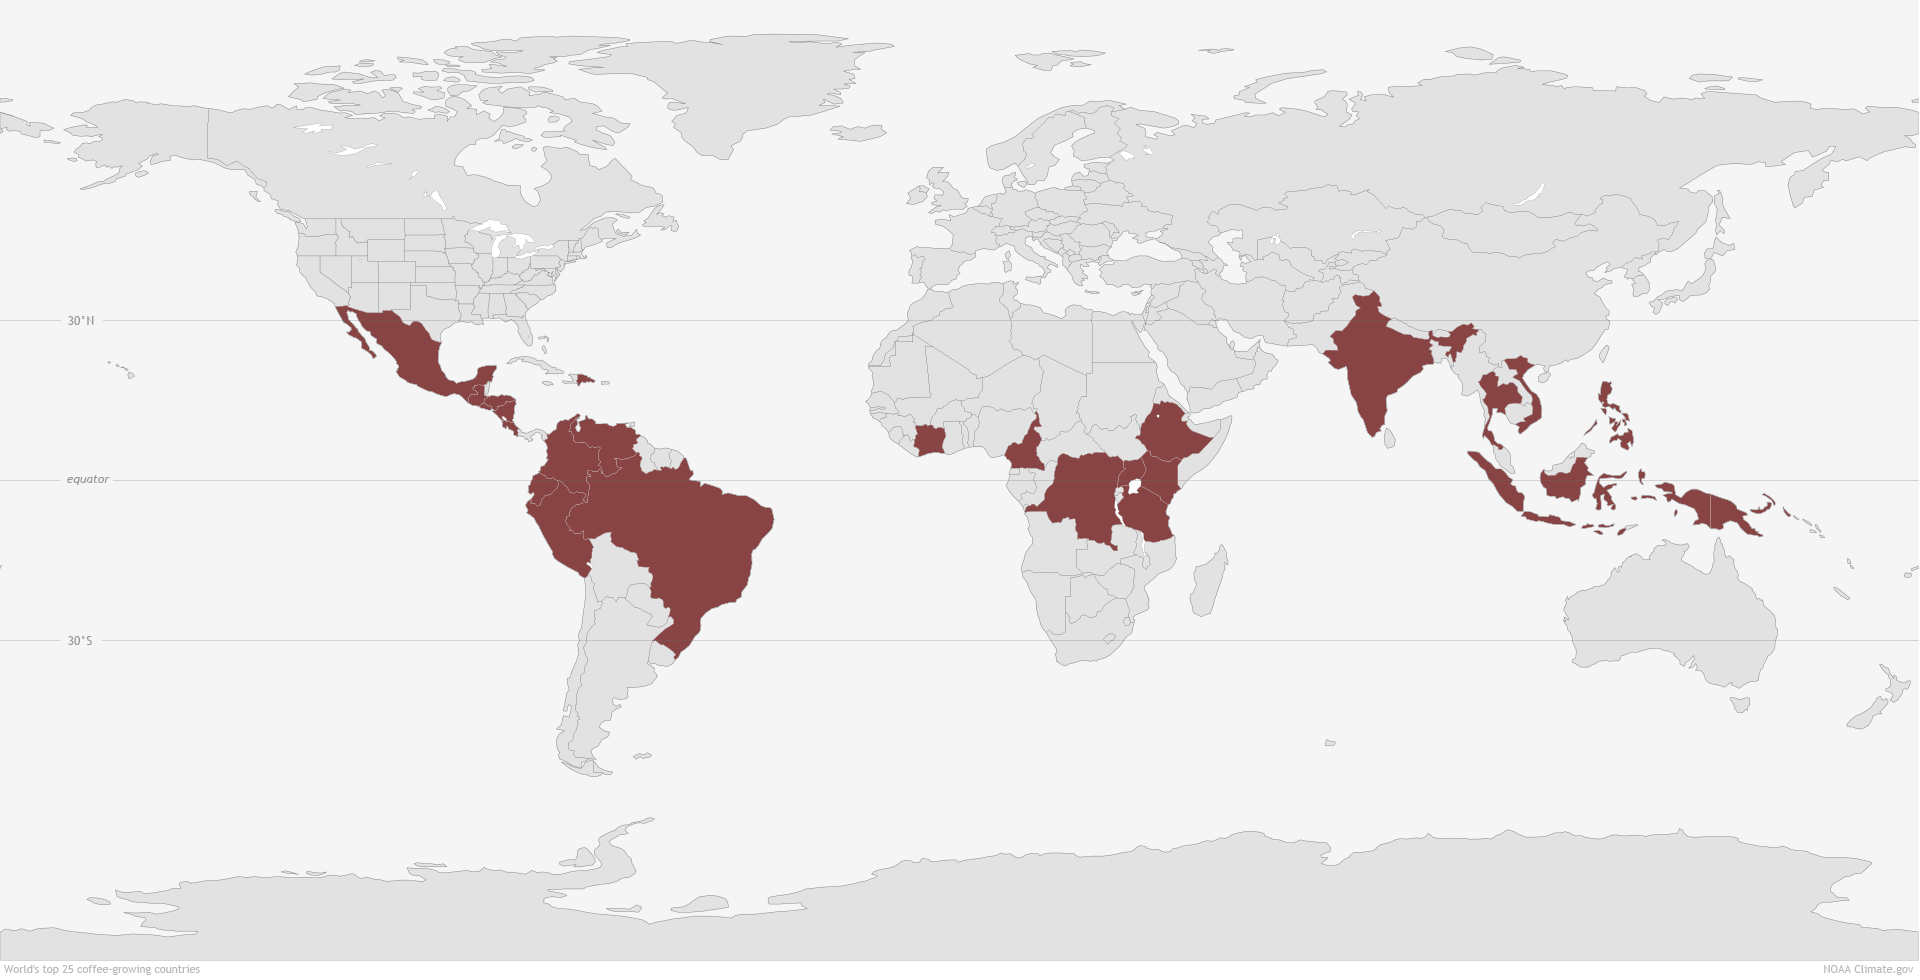

In [14]:
from mpl_toolkits.basemap import Basemap

arabica_producing_locations = pd.DataFrame(stations_in_arabica_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")
robusta_producing_locations = pd.DataFrame(stations_in_robusta_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")

arabica_longitudes = arabica_producing_locations["Longitude"].tolist()
arabica_latitudes = arabica_producing_locations["Latitude"].tolist()

robusta_longitudes = robusta_producing_locations["Longitude"].tolist()
robusta_latitudes = robusta_producing_locations["Latitude"].tolist()


fig = plt.figure(figsize = (10,16))
station_map = Basemap()

arabica_x, arabica_y = station_map(arabica_longitudes, arabica_latitudes)
station_map.scatter(arabica_x, arabica_y, color='b')

robusta_x, robusta_y = station_map(robusta_longitudes, robusta_latitudes)
station_map.scatter(robusta_x, robusta_y, color='r')


station_map.drawcoastlines()
station_map.drawcountries()

plt.title("Coffee growing regions in Berkeley Earth data")
plt.legend(["Arabica", "Robusta"], loc = 'center left')
plt.show()

# Show top growing countries, for comparison
from IPython.display import Image
Image("https://www.climate.gov/sites/default/files/CoffeeGrowingCountries_large.jpg")

### Exporting final temperatures dataframe

In [15]:
temperature_data.head()

,Country,Temperature (C),Hemisphere,Arabica Production,Robusta Production,Season,Frost likelihood
1849-01-01,Sierra Leone,23.905,Northern,False,True,Winter,0.001750
1849-02-01,Sierra Leone,24.080,Northern,False,True,Winter,0.001725
1849-03-01,Sierra Leone,24.092,Northern,False,True,Winter,0.001723
1849-04-01,Sierra Leone,23.185,Northern,False,True,Spring,0.001860
1849-05-01,Sierra Leone,22.837,Northern,False,True,Spring,0.001917


In [16]:
temperature_data.to_csv("../datasets/capstone/temperature-in-coffee-growing-regions--from-berkeley-earth.csv")